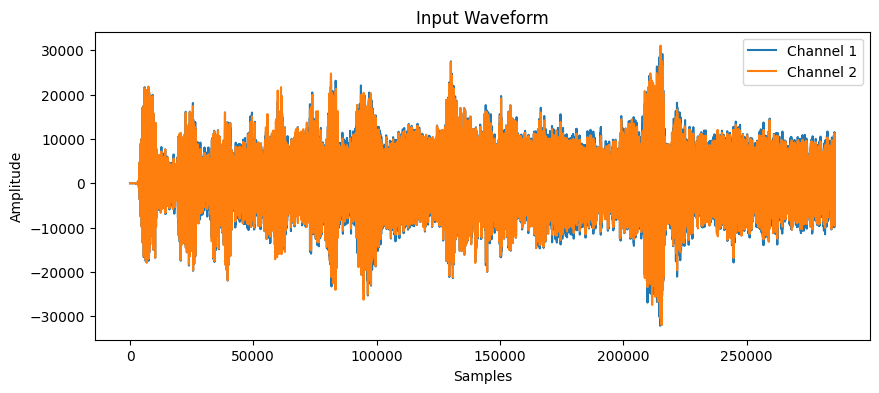

C:\Users\Nimma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_incremental_pca.py:354: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio = S**2 / np.sum(col_var * n_total_samples)


Shape of Covariance Matrix: (2, 2)
Shape of Eigen Values: (2,), Eigen Vectors: (2, 2), Whitened Data: (2, 285696)


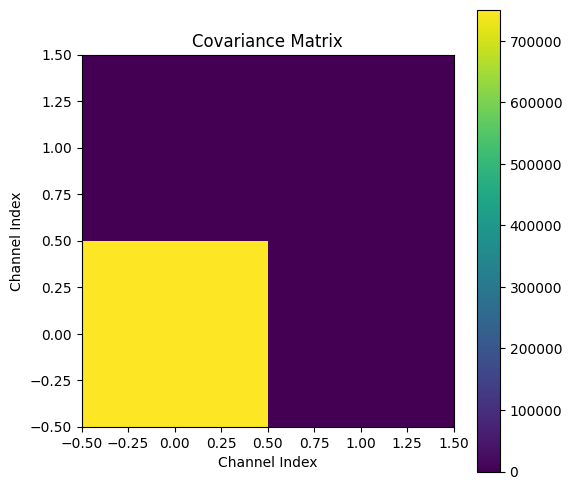

Component: 1/2, Step: 1/100, Distance: 0.07664210758809786
Convergence attained for the 1/2 component.
Component: 1/2, Step: 10/100, Distance: 7.5728180906065035e-06

Component: 2/2, Step: 1/100, Distance: 0.9038866029925037
Component: 2/2, Step: 51/100, Distance: 0.004343256355311187


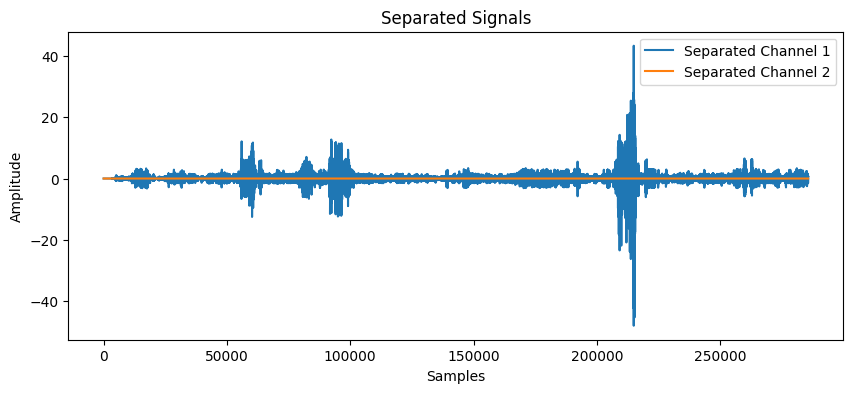

Separated signals saved in the output folder.


In [1]:
import numpy as np
import scipy.io.wavfile as wf
import os
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

# Define center and whiten functions
def center(x):
    x = np.array(x)
    return x - x.mean(axis=1, keepdims=True)

def whiten(x, num_components=None):
    pca = IncrementalPCA(n_components=num_components)
    x_pca = pca.fit_transform(x)

    cov_matrix = np.cov(x_pca, rowvar=False)
    eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)
    D = np.diag(eigen_values)
    sqrt_inverse_D = np.sqrt(np.linalg.inv(D))
    x_whiten = eigen_vectors @ sqrt_inverse_D @ (eigen_vectors.T @ x_pca.T)

    print(f'Shape of Covariance Matrix: {cov_matrix.shape}')
    print(f'Shape of Eigen Values: {eigen_values.shape}, Eigen Vectors: {eigen_vectors.shape}, Whitened Data: {x_whiten.shape}')

    return x_whiten, D, eigen_vectors, cov_matrix

def objFunc(x):
    return np.tanh(x)

def dobjFunc(x):
    return 1 - (objFunc(x) ** 2)

def calc_w_hat(W, X):
    w_hat = (X * objFunc(W.T @ X)).mean(axis=1) - dobjFunc(W.T @ X).mean() * W
    w_hat /= np.sqrt((w_hat ** 2).sum())
    return w_hat

def ica(X, iterations, tolerance=1e-5):
    num_components = X.shape[0]
    W = np.zeros((num_components, num_components), dtype=X.dtype)
    distances = {i: [] for i in range(num_components)}

    for i in range(num_components):
        w_new = np.random.rand(num_components)
        for j in range(iterations):
            w = w_new
            w_new = calc_w_hat(w, X)

            if i > 0:
                # Subtract projection on previous components
                w_new -= np.sum(np.dot(w_new, W[:, :i]) * W[:, :i], axis=1)

            distance = np.abs(np.abs((w @ w_new).sum()) - 1)
            if distance < tolerance:
                W[:, i] = w_new
                print(f'Convergence attained for the {i+1}/{num_components} component.')
                print(f'Component: {i+1}/{num_components}, Step: {j+1}/{iterations}, Distance: {distance}\n')
                break

            distances[i].append(distance)

            if j % 50 == 0:
                print(f'Component: {i+1}/{num_components}, Step: {j+1}/{iterations}, Distance: {distance}')

    S = np.dot(W.T, X)
    return S, distances

# File paths
input_wav_path = r"C:\Users\Nimma\Videos\Input_disam\disambiguation.wav"
output_folder_path = r"C:\Users\Nimma\Videos\Output_disam"

if not os.path.exists(input_wav_path):
    print("Error: Input file does not exist.")
    exit()

if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Load the input audio
sampling_rate, x = wf.read(input_wav_path)

# Reshape if necessary
if len(x.shape) > 1:
    x = x.reshape(-1, 2)

# Plot the input waveform
plt.figure(figsize=(10, 4))
plt.plot(x[:, 0], label='Channel 1')
plt.plot(x[:, 1], label='Channel 2')
plt.title('Input Waveform')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.savefig(os.path.join(output_folder_path, 'input_waveform.png'))
plt.show()

# Center the data
x_centered = center(x)

# Whiten the centered data
X_whiten, _, _, cov_matrix = whiten(x_centered)

# Plot covariance matrix
plt.figure(figsize=(6, 6))
plt.imshow(cov_matrix, cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Covariance Matrix')
plt.xlabel('Channel Index')
plt.ylabel('Channel Index')
plt.savefig(os.path.join(output_folder_path, 'covariance_matrix.png'))
plt.show()

# Perform ICA
S, _ = ica(X_whiten, iterations=100)

# Plot separated signals
plt.figure(figsize=(10, 4))
plt.plot(S[0], label='Separated Channel 1')
plt.plot(S[1], label='Separated Channel 2')
plt.title('Separated Signals')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.savefig(os.path.join(output_folder_path, 'separated_signals.png'))
plt.show()

# Save separated audio signals
wf.write(os.path.join(output_folder_path, 's1_predicted.wav'), sampling_rate, S[0].astype(np.float32))
wf.write(os.path.join(output_folder_path, 's2_predicted.wav'), sampling_rate, S[1].astype(np.float32))

print("Separated signals saved in the output folder.")